**Peak finder algorithm**
a,b,c,d,e,f,g,h,i
 
b is a peak if $b \geq a$ and $b \geq c$ (With such a statement, an array will always have a peak) 

In [79]:
import pandas as pd

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy
import math

In [8]:
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [1]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [4]:
frames = []

#path = "20210615_145527.mp4"
#path = "20210616_190814.mp4"
#path = "20210616_192742.mp4"
#path = "20210619_111818.mp4" #light touch on the camera
#path = "20210619_113706.mp4" #light touch on camera
#path = "20210619_114150.mp4" #on the wrist
#path= "20210621_121649.mp4" #Anant's heart beat.
path = "20210622_130755.mp4" #Mona's heart beat
cap = cv2.VideoCapture(path)
#get the framerate
fps = cap.get(cv2.CAP_PROP_FPS)
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
        frames.append(img)
video = np.stack(frames, axis=0) # dimensions (T, H, W, C) #BGR format

print("Shape of the ND array = {}".format(video.shape))
vB = video[:,:,:,0]
vG = video[:,:,:,1]
vR = video[:,:,:,2]

Shape of the ND array = (461, 1920, 1080, 3)


In [5]:
#set parameters here
final = vR #select the channnel
w=700 #select the width
h=700 #select the height

Shape of a cropped frame = (461, 700, 700)
Pulse Rate = 91.29 Beats/Minute


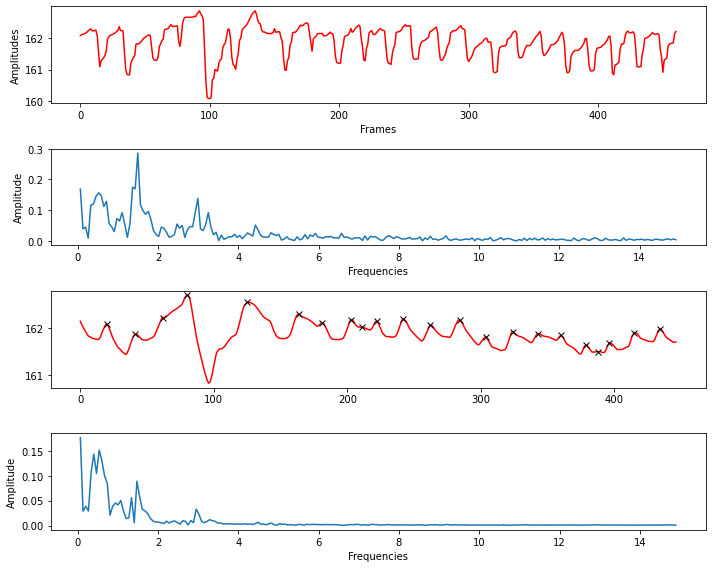

In [6]:
#lets get the center pixel. Recall that the first dimension([0]) is frame number.

centerPixelX = final.shape[1]//2; centerPixelY = final.shape[2]//2-1000


croppedR = final[:,centerPixelX-w//2:centerPixelX-w//2+w,centerPixelY-h//2:centerPixelY-h//2+h]
print("Shape of a cropped frame = {}".format(croppedR.shape))

#run for loop for all the frames
final_SumofPixels = []
for i in range(0,croppedR.shape[0]):
    final_SumofPixels.append(croppedR[i:i+1,:,:].sum()/(croppedR.shape[1]*final.shape[2]))

#plot the sum of pixels
fig, ax = plt.subplots(4,1, figsize=(10,8))
ax[0].plot(range(0,croppedR.shape[0]), final_SumofPixels, color='red');
ax[0].set_xlabel('Frames')
ax[0].set_ylabel('Amplitudes')

#compute fft
FS, HS = compute_fft(final_SumofPixels, fps, scale_amplitudes=True)
ax[1].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[1].set_xlabel('Frequencies')
ax[1].set_ylabel('Amplitude');

#filter using convolution
size = 15
#window = np.random.rand(size)
window = np.ones(size)/size
filteredA = np.convolve(final_SumofPixels, window, mode='valid')
peaks,_ = find_peaks(filteredA)
ax[2].plot(range(0,croppedR.shape[0]-(size-1)), filteredA, color='red');
ax[2].plot(peaks, [filteredA[i] for i in peaks], "x", color='black')


#compute fft of filtered signal
FS, HS = compute_fft(filteredA, fps, scale_amplitudes=True)
ax[3].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[3].set_xlabel('Frequencies')
ax[3].set_ylabel('Amplitude');


#find the average difference between the peaks
avgdifferenceBetweenPeaks = np.array([peaks[i] - peaks[i-1] for i in range(1,len(peaks))]).mean()
print("Pulse Rate = {:.2f} Beats/Minute".format( (fps/avgdifferenceBetweenPeaks)*60 ))


fig.tight_layout()
#ax.set_ylim(55,60)

### With Gaussian Window

Shape of a cropped frame = (461, 700, 700)
Pulse Rate = 82.60 Beats/Minute


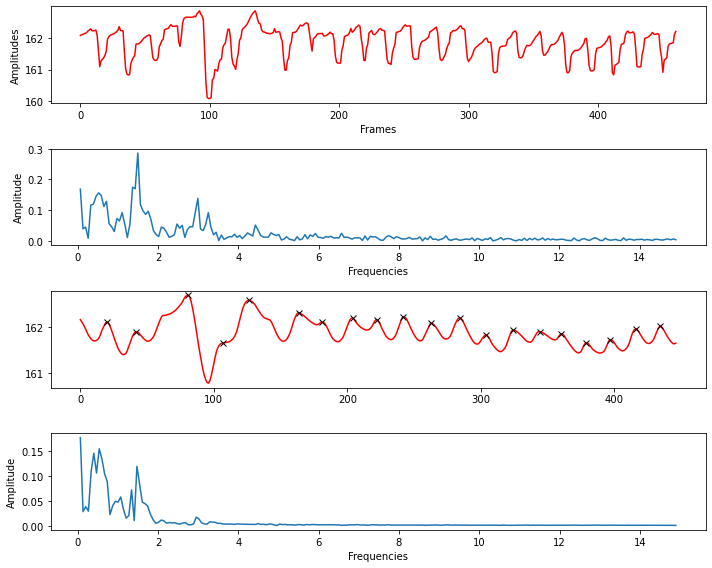

In [7]:
#lets get the center pixel. Recall that the first dimension([0]) is frame number.
centerPixelX = final.shape[1]//2; centerPixelY = final.shape[2]//2-1000
croppedR = final[:,centerPixelX-w//2:centerPixelX-w//2+w,centerPixelY-h//2:centerPixelY-h//2+h]
print("Shape of a cropped frame = {}".format(croppedR.shape))

#run for loop for all the frames
final_SumofPixels = []
for i in range(0,croppedR.shape[0]):
    final_SumofPixels.append(croppedR[i:i+1,:,:].sum()/(croppedR.shape[1]*final.shape[2]))

#plot the sum of pixels
fig, ax = plt.subplots(4,1, figsize=(10,8))
ax[0].plot(range(0,croppedR.shape[0]), final_SumofPixels, color='red');
ax[0].set_xlabel('Frames')
ax[0].set_ylabel('Amplitudes')

#compute fft
FS, HS = compute_fft(final_SumofPixels, fps, scale_amplitudes=True)
ax[1].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[1].set_xlabel('Frequencies')
ax[1].set_ylabel('Amplitude');

#filter using convolution
size = 15
window = scipy.signal.gaussian(M=size, std=6)
window /= window.sum()
filteredA = np.convolve(final_SumofPixels, window, mode='valid')
peaks,_ = find_peaks(filteredA)
ax[2].plot(range(0,croppedR.shape[0]-(size-1)), filteredA, color='red');
ax[2].plot(peaks, [filteredA[i] for i in peaks], "x", color='black')


#compute fft of filtered signal
FS, HS = compute_fft(filteredA, fps, scale_amplitudes=True)
ax[3].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[3].set_xlabel('Frequencies')
ax[3].set_ylabel('Amplitude');


#find the average difference between the peaks
avgdifferenceBetweenPeaks = np.array([peaks[i] - peaks[i-1] for i in range(1,len(peaks))]).mean()
print("Pulse Rate = {:.2f} Beats/Minute".format( (fps/avgdifferenceBetweenPeaks)*60 ))


fig.tight_layout()
#ax.set_ylim(55,60)

#### Why does Gaussian window work better?

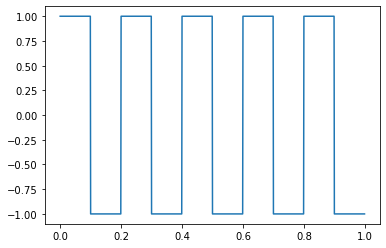

In [114]:
from scipy import signal
t = np.linspace(0, 1, 1000, endpoint=False)
y = signal.square(2 * np.pi * 5 * t)
plt.plot(t, y)

In [115]:
len(y)

1000

In [110]:
window = np.sin(2*np.pi*200*np.linspace(0,1,50))
window

array([ 0.00000000e+00,  4.90717552e-01,  8.55142763e-01,  9.99486216e-01,
        8.86599306e-01,  5.45534901e-01,  6.40702200e-02, -4.33883739e-01,
       -8.20172255e-01, -9.95379113e-01, -9.14412623e-01, -5.98110530e-01,
       -1.27877162e-01,  3.75267005e-01,  7.81831482e-01,  9.87181783e-01,
        9.38468422e-01,  6.48228395e-01,  1.91158629e-01, -3.15108218e-01,
       -7.40277997e-01, -9.74927912e-01, -9.58667853e-01, -6.95682551e-01,
       -2.53654584e-01,  2.53654584e-01,  6.95682551e-01,  9.58667853e-01,
        9.74927912e-01,  7.40277997e-01,  3.15108218e-01, -1.91158629e-01,
       -6.48228395e-01, -9.38468422e-01, -9.87181783e-01, -7.81831482e-01,
       -3.75267005e-01,  1.27877162e-01,  5.98110530e-01,  9.14412623e-01,
        9.95379113e-01,  8.20172255e-01,  4.33883739e-01, -6.40702200e-02,
       -5.45534901e-01, -8.86599306e-01, -9.99486216e-01, -8.55142763e-01,
       -4.90717552e-01,  7.85754689e-15])

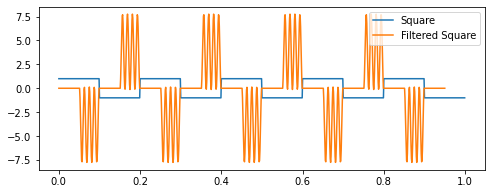

In [116]:
#window = np.ones(10)/10
#window = scipy.signal.gaussian(M=10, std=6)
new_y = np.convolve(y,window, mode='valid')
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(t,y)
ax.plot(t[:len(new_y)],new_y)
ax.legend(['Square','Filtered Square'])

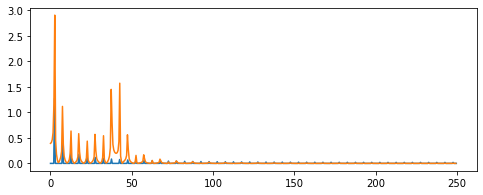

In [125]:
FS, HS = compute_fft(y, 500)
FS_f, HS_f = compute_fft(new_y, 500)
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(FS, HS)
ax.plot(FS_f, HS_f)


In [120]:
len(HS_f)

475

In [121]:
len(HS)

500

In [126]:
df = pd.DataFrame({'Filtered':HS_f,'Original':HS[25:]})

<AxesSubplot:>

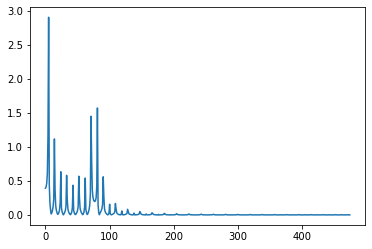

In [127]:
df['ratio'] = df.Filtered/df.Original
df['ratio'] = df.replace(np.inf,np.nan)
df['ratio'].plot(kind='line')

In [68]:
HS

array([ 20.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        22.82306007,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        37.32549433,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       318.5194222 ,   0.        ,   0.        ,   0.  

In [128]:
window = scipy.signal.gaussian(M=10, std=6)
window

array([0.7548396 , 0.84354765, 0.91685536, 0.96923323, 0.9965338 ,
       0.9965338 , 0.96923323, 0.91685536, 0.84354765, 0.7548396 ])

In [129]:
window = scipy.signal.gaussian(M=10, std=6)
window

array([0.7548396 , 0.84354765, 0.91685536, 0.96923323, 0.9965338 ,
       0.9965338 , 0.96923323, 0.91685536, 0.84354765, 0.7548396 ])